# Sprint 2: Unsupervised learning
In dit deel wordt de K-means clustering methode gebruikt om de categorieën van products en issues te bepalen waartoe de klachten behoren. Deze keer wordt aan unsupervised learning gedaan, wat betekent dat de categorieën niet vooraf bepaald worden, in tegenstelling tot supervised learning. We laten de models dus zelf bepalen wat de onderverdelingen zijn.

K-means is een methode die de data opdeelt in k clusters. Initieel worden k punten gekozen als clusters, willekeurig of aan de hand van een algoritme. Vervolgens wordt de cluster waartoe een ander punt behoort bepaald door de afstand van het punt tot het gemiddelde van de cluster. Dit proces wordt verschillende keren herhaald waarna de configuratie met de kleinste totale variantie van de punten in de clusters gekozen wordt als beste configuratie.

Een manier om de beste waarde voor k te kiezen is de *elbow method*. Hierbij worden verschillende waarden voor k getest en wordt de verandering in de totale variantie van de data geplot (hoe groter k, hoe kleiner de totale varantie). Deze totale variantie (inertia) is de som van de kwadraten van de afstanden van de punten tot het midden van hun cluster. De beste waarde voor k is dan de 'elleboog' van de geplotte functie. Dit is het punt waar de vermindering van de variantie significant groter is dan die bij het volgende punt.

## Inlezen data
We beginnen opnieuw met het inlezen van de complaints. Enkel volgende kolommen worden bijgehouden in de complaints dataframe:
* Product
* Sub-product
* Issue
* Sub-issue
* Consumer complaint narrative

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

complaints = pd.read_csv('../data/complaints.csv', delimiter=',')
complaints = complaints[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()
complaints.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...


## Data pre-processing
De volgende stap is om de data geschikt te maken voor clustering, aan de hand van pre-processing technieken. Dit wordt op dezelfde manier gedaan als in de vorige sprint. We passen onder andere tokenization en stemming (werkwoorden en andere woorden reduceren tot hun stamvorm) toe en we verwijderen stopwoorden.

In [13]:
complaints.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

<Figure size 720x360 with 0 Axes>

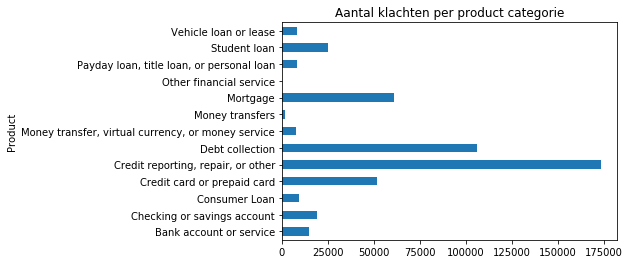

In [29]:
product_counts = pd.DataFrame({'Count': complaints.groupby(['Product']).size()})
fig = plt.figure(figsize=(10, 5))
product_counts.plot.barh(title="Aantal klachten per product categorie", legend=None)

In [30]:
def sampling_k_elements(category, k=5000):
    if len(category) < k:
        return category
    return category.sample(k)

balanced = complaints.groupby('Product').apply(sampling_k_elements).reset_index(drop=True)

<Figure size 720x360 with 0 Axes>

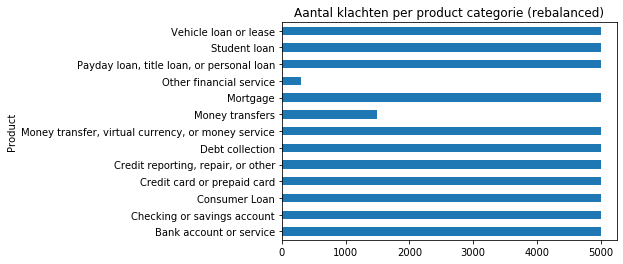

In [31]:
balanced_counts = pd.DataFrame({'Count': balanced.groupby(['Product']).size()})
fig = plt.figure(figsize=(10, 5))
balanced_counts.plot.barh(title="Aantal klachten per product categorie (rebalanced)", legend=None)

In [32]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thoma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    # stopwoorden verwijderen en woorden die bestaan uit maximum 3 karakters weglaten
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    # werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return ' ' . join(result)

In [38]:
balanced['Narrative_processed'] = balanced['Narrative'].apply(processing)
balanced[['Narrative','Narrative_processed']].head()

,Narrative,Narrative_processed
0,"Being a first time, single mother, I had to ma...",time singl mother make decis overdraft protect...
1,My parents bank with a well known bank that I ...,parent bank know bank fear retribut account pa...
2,The US Bank cancelled my Checking Account 's O...,bank cancel check account overdraft coverag no...
3,I had a levy from a debt collector and law fir...,levi debt collector firm base place bank ameri...
4,I contacted USAA bank to dispute a charge afte...,contact usaa bank disput charg compani fail wo...


## Feature extraction
Om de woorden om te zetten in bruikbare data maken we nieuwe features aan de hand van een CountVectorizer. Deze converteert de token sets naar een ijle matrix van token counts. De matrix is ijl (sparse) omdat de meeste elementen nul zijn of dicht bij nul liggen.

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.97)
X = vectorizer.fit_transform(balanced['Narrative_processed'])

In [40]:
# print(X)
#vectorizer.vocabulary_
print('Er zijn %d unieke woorden.' % X.shape[1])
# plt.scatter(X[:,0], X[:,1], s=20)
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

Er zijn 7777 unieke woorden.


## K-means
Nu kan de K-means methode toegepast worden op de matrix. We beginnen met 20 verschillende waarden voor k uit te testen, om daarna aan de hand van de *elbow method* de beste waarde te kiezen. Initieel worden dus onderverdelingen gemaakt met 1 tot en met 20 clusters.

In [46]:
%%time

from sklearn.cluster import KMeans
#List voor bijhouden van WCSS (Within-Cluster-Sum-of-Squares):
inertia = []
k_min = 1
k_max = 11
for i in range(k_min, k_max):
    print(i)
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

1
2
3
4
5
6
7
8
9
10
Wall time: 2h 1min 50s


In [47]:
%%time

k_min = 11
k_max = 21
for i in range(k_min, k_max):
    print(i)
    kmeans = KMeans(n_clusters = i, n_jobs = -1)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

11
12
13
14
15
16
17
18
19
20
Wall time: 3h 17min 2s


De totale varianties van de punten in de clusters per waarde voor k zitten nu in de lijst *inertia*. Dit staat ons toe om deze in een grafiek te zetten en de *elbow* van de functie te vinden.

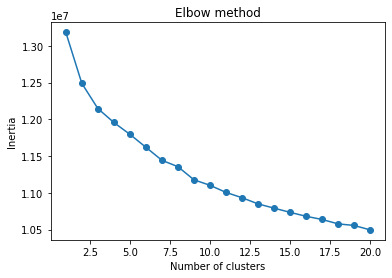

In [61]:
plt.plot(range(1,21), inertia, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [62]:
k = 9
model = KMeans(n_clusters = k, n_jobs = -1)
model.fit(X)

print("Meest voorkomende woorden per cluster:")
cluster_centers = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i)
    for j in cluster_centers[i, :10]:
        print(' %s' % terms[j])
    print("\n")

Meest voorkomende woorden per cluster:
Cluster 0:
 loan
 payment
 tell
 time
 month
 pay
 call
 receiv
 inform
 year


Cluster 1:
 account
 payment
 credit
 loan
 call
 bank
 tell
 receiv
 time
 report


Cluster 2:
 payment
 account
 month
 loan
 tell
 time
 make
 call
 receiv
 credit


Cluster 3:
 well
 fargo
 account
 bank
 check
 payment
 tell
 loan
 receiv
 inform


Cluster 4:
 consum
 inform
 report
 block
 agenc
 section
 ident
 theft
 shall
 file


Cluster 5:
 credit
 report
 account
 inform
 card
 debt
 receiv
 compani
 payment
 disput


Cluster 6:
 archiv
 complet
 card
 debit
 purchas
 signatur
 paypal
 transfer
 receiv
 credit


Cluster 7:
 account
 bank
 check
 tell
 receiv
 inform
 say
 call
 money
 time


Cluster 8:
 account
 bank
 check
 money
 tell
 call
 receiv
 time
 say
 send




In [48]:
def plotClusters2D(data, cluster_labels, cluster_centers = None):  
    unique_labels = set(cluster_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]        

        plt.scatter(data[cluster_labels == k,0],data[cluster_labels == k,1],s=20,c=[col])

    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=250, marker='*', c='red', edgecolor='black')
  
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = ..., n_jobs = -1)
y_km = km.fit_predict(X)
plotClusters2D(X,y_km,km.cluster_centers_)